In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv("../dataset_full_texts.csv")
data.head()

,doc_id,url,cache,fulltext,nature,published,entity_name,entity_type,geo_path,extracted_text
0,2713/e87b2_Plan_Action_CASGBS.pdf,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMERATION SAINT GERMAIN BOUCL...
1,2713/9eef1_Resume_Non_Techniques_CASGBS.pdf,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMÉRATION SAINT GERMAIN BOUCL...
2,2713/e3f75_Evaluation_Environnementale_Strateg...,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMÉRATION SAINT GERMAIN BOUCL...
3,2713/6ed88_Rapport-Strategique_CASGBS.pdf,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMÉRATION SAINT GERMAIN BOUCL...
4,1796/69a6d_chinon_actus_octobre_2022_stc.pdf,https://www.ville-chinon.com/fileadmin/contenu...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,Chinon,Commune,"Chinon/CC Chinon, Vienne et Loire/Indre-et-Loi...",chinon le mag MAgazine MUNICIPAL / octobre 202...


In [19]:
data.shape

(16172, 10)

In [20]:
data["nature"].value_counts()

nature
comm              3688
pv.cr             2755
dlao.plu          2573
acte.delib        1168
other              694
acte.arrete        518
pv.full            434
bdj                269
dlao.autres        174
acte.raa            35
mp.reglement         3
bdj.annexes          2
rapport              2
mp.annonce           1
comm.demarches       1
Name: count, dtype: int64

In [21]:
data_sample_comm = data[data["nature"] == "comm"].sample(2000, random_state=42)

In [22]:
data_sample_comm.to_csv("data_experiments.csv", index=False)

## Computing Text Embeddings

In [23]:
import torch
device = torch.device("cuda")

In [24]:
from sentence_transformers import SentenceTransformer

model =  SentenceTransformer("dangvantuan/sentence-camembert-base")

In [25]:
# look for better embedding workflow?
data_sample_comm["embeddings"] = data_sample_comm["extracted_text"].apply(lambda text: model.encode(text))

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\camembert\modeling_camembert.py:388: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


## Clustering

In [26]:
text_embeddings = data_sample_comm["embeddings"].to_list()

In [27]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

In [28]:
def create_evaluate_cluster(clustering_algorithm, X, n_clusters, nearest_centroid=False):
    
    clustering_algorithm.fit(X)
    labels = clustering_algorithm.labels_
    
    sil_score = silhouette_score(X, labels, random_state=42)
    cal_score = calinski_harabasz_score(X, labels)

    if nearest_centroid == True:
        cluster_centers = NearestCentroid().fit(X, labels).centroids_
    else:
        cluster_centers = clustering_algorithm.cluster_centers_
        
    distorsion = sum(np.min(cdist(X, cluster_centers, 'euclidean'), axis=1)) / len(X)

    print(f"Clustering Algorithm: {clustering_algorithm}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Silhouette score: {sil_score}")
    print(f"Calinski score: {cal_score}")
    print()
    
    return clustering_algorithm, sil_score, cal_score, distorsion, labels
    

In [29]:
import numpy as np
ns_clusters = list(np.arange(2, 6, 1))
print(ns_clusters)

[2, 3, 4, 5]


In [30]:
k_silhouette_scores = []
K_calinski_scores = []
k_distorsions = []
k_labels = []

for n_clusters in ns_clusters:
    kmeans, sil_score, cal_score, distorsion, labels = create_evaluate_cluster(KMeans(n_clusters=n_clusters, random_state=40), text_embeddings, n_clusters)
    k_silhouette_scores.append(sil_score)
    K_calinski_scores.append(cal_score)
    k_distorsions.append(distorsion)
    k_labels.append(labels)

Clustering Algorithm: KMeans(n_clusters=2, random_state=40)
Number of clusters: 2
Silhouette score: 0.3049520254135132
Calinski score: 315.8850559851284

Clustering Algorithm: KMeans(n_clusters=3, random_state=40)
Number of clusters: 3
Silhouette score: 0.08006773144006729
Calinski score: 214.9238428614833

Clustering Algorithm: KMeans(n_clusters=4, random_state=40)
Number of clusters: 4
Silhouette score: 0.0840320885181427
Calinski score: 183.7164214194589

Clustering Algorithm: KMeans(n_clusters=5, random_state=40)
Number of clusters: 5
Silhouette score: 0.0730104148387909
Calinski score: 149.91712080226665



In [31]:
ag_silhouette_scores = []
ag_calinski_scores = []
ag_distorsions = []
agg_labels = []

for n_clusters in ns_clusters:
    agg_cluster, sil_score, cal_score, distorsion, labels = create_evaluate_cluster(AgglomerativeClustering(n_clusters=n_clusters, compute_distances=True), text_embeddings, n_clusters, nearest_centroid=True)
    ag_silhouette_scores.append(sil_score)
    ag_calinski_scores.append(cal_score)
    ag_distorsions.append(distorsion)
    agg_labels.append(labels)

Clustering Algorithm: AgglomerativeClustering(compute_distances=True)
Number of clusters: 2
Silhouette score: 0.3033903241157532
Calinski score: 314.9338211235616

Clustering Algorithm: AgglomerativeClustering(compute_distances=True, n_clusters=3)
Number of clusters: 3
Silhouette score: 0.07417340576648712
Calinski score: 206.6358260788697

Clustering Algorithm: AgglomerativeClustering(compute_distances=True, n_clusters=4)
Number of clusters: 4
Silhouette score: 0.07212809473276138
Calinski score: 166.89704250583236

Clustering Algorithm: AgglomerativeClustering(compute_distances=True, n_clusters=5)
Number of clusters: 5
Silhouette score: 0.0660490021109581
Calinski score: 135.73531146024482



In [32]:
data_sample_comm["km_cluster_labels"] = k_labels[0]
data_sample_comm["agg_cluster_labels"] = agg_labels[0]

In [33]:
data_sample_comm["km_cluster_labels"].value_counts()

km_cluster_labels
0    1870
1     130
Name: count, dtype: int64

In [34]:
data_sample_comm["agg_cluster_labels"].value_counts()

agg_cluster_labels
0    1871
1     129
Name: count, dtype: int64

In [35]:
# samples where they differ
data_sample_comm[(data_sample_comm["km_cluster_labels"] == 1 ) & (data_sample_comm["agg_cluster_labels"] != 1)]

,doc_id,url,cache,fulltext,nature,published,entity_name,entity_type,geo_path,extracted_text,embeddings,km_cluster_labels,agg_cluster_labels
13211,2578/f4d9e5fbe7bfa06e463483bdfa643382590a812f_...,https://domme-villefranche-du-perigord.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,comm,2024-06-01 00:00:00,CC de Domme-Villefranche du Périgord,Intercommunalité,CC de Domme-Villefranche du Périgord/Dordogne/...,PROJET D’AMÉNAGEMENT ET DE DÉVELOPPEMENT DURAB...,"[-0.004360735, 0.027144723, 0.017031213, 0.053...",1,0


In [39]:
data_sample_comm.to_csv("data_experiments.csv", index=False)

### Qualitative Results

In [1]:
import pandas as pd
data_sample_comm = pd.read_csv("data_experiments.csv")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

nlp = spacy.load("fr_core_news_sm")

def preprocess_tokenize(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_stop == False and token.is_alpha]
    return tokens

tf = TfidfVectorizer(tokenizer=preprocess_tokenize, max_features=5000)
X = data_sample_comm["extracted_text"]

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_uri" in _BaseYandexGPT has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in _BaseYandexGPT has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_version" in _BaseYandexGPT has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
tf_matrix = tf.fit_transform(X)
feature_names = tf.get_feature_names_out()

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
tf_idf_matrix_df = pd.DataFrame(tf_matrix.toarray(), columns=feature_names)

In [5]:
tf_idf_matrix_df.shape

(2000, 5000)

In [6]:
data_sample_comm.shape

(2000, 10)

In [40]:
df_tfidf = pd.concat([data_sample_comm.reset_index(drop=True), tf_idf_matrix_df.reset_index(drop=True)], axis=1)
df_tfidf.shape

(2000, 5013)

In [41]:
df_tfidf.to_csv("tf_matrix_comm_sample.csv", index=False)

#### Classifier to perform SHAP

In [42]:
import pandas as pd
df_tfidf = pd.read_csv("tf_matrix_comm_sample.csv")

In [48]:
df_tfidf.columns[:13]

Index(['doc_id', 'url', 'cache', 'fulltext', 'nature', 'published',
       'entity_name', 'entity_type', 'geo_path', 'extracted_text',
       'embeddings', 'km_cluster_labels', 'agg_cluster_labels'],
      dtype='object')

In [49]:
x_cols = list(df_tfidf.columns)[14:]

##### RFE

In [73]:
X = df_tfidf[x_cols]
y = df_tfidf["km_cluster_labels"]

In [75]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe = RFE(RandomForestClassifier(random_state=42))
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(random_state=42))

In [80]:
feature_names = list(rfe.feature_names_in_)
ranking = list(rfe.ranking_)

In [89]:
dict_fts_rfe = {"feature": feature_names, "rank": ranking}

In [93]:
df_ranking = pd.DataFrame.from_dict(dict_fts_rfe)

In [100]:
# df_ranking.sort_values("rank", ascending=True)

In [99]:
df_ranking["rank"].value_counts()

rank
1       2499
1300       1
1318       1
1294       1
1320       1
        ... 
652        1
682        1
618        1
675        1
2423       1
Name: count, Length: 2501, dtype: int64

In [94]:
df_ranking[df_ranking["rank"] == 1]

,feature,rank
526,bien,1
527,bientôt,1
528,bienveillance,1
529,bienvenu,1
530,bienvenue,1
...,...,...
4735,ville,1
4836,zone,1
4864,économique,1
4924,énergie,1


In [96]:
top_features = df_ranking[df_ranking["rank"] == 1]["feature"].to_list()

##### Random Forest

In [101]:
X = X[top_features]

In [102]:
X.shape

(2000, 2499)

In [103]:
y.shape

(2000,)

In [104]:
rf = RandomForestClassifier(random_state=40)
rf.fit(X, y)

RandomForestClassifier(random_state=40)

Feature Importance

In [105]:
rf.feature_importances_

array([0.00326149, 0.        , 0.        , ..., 0.00218005, 0.01601879,
       0.01460645])

In [106]:
rf.feature_names_in_

array(['bien', 'bientôt', 'bienveillance', ..., 'économique', 'énergie',
       'énergétique'], dtype=object)

In [163]:
rf_feature_importance = {"feature": rf.feature_names_in_, "importance": rf.feature_importances_}
df_importance = pd.DataFrame.from_dict(rf_feature_importance)
df_imp_sorted = df_importance.sort_values("importance", ascending=False)
df_imp_slice = df_imp_sorted[:30]
most_rel_features = list(df_imp_slice.index)

In [164]:
df_imp_slice.head()

,feature,importance
1239,géothermie,0.048852
2489,travail,0.042231
1558,projet,0.041944
1642,public,0.037413
2209,service,0.025205


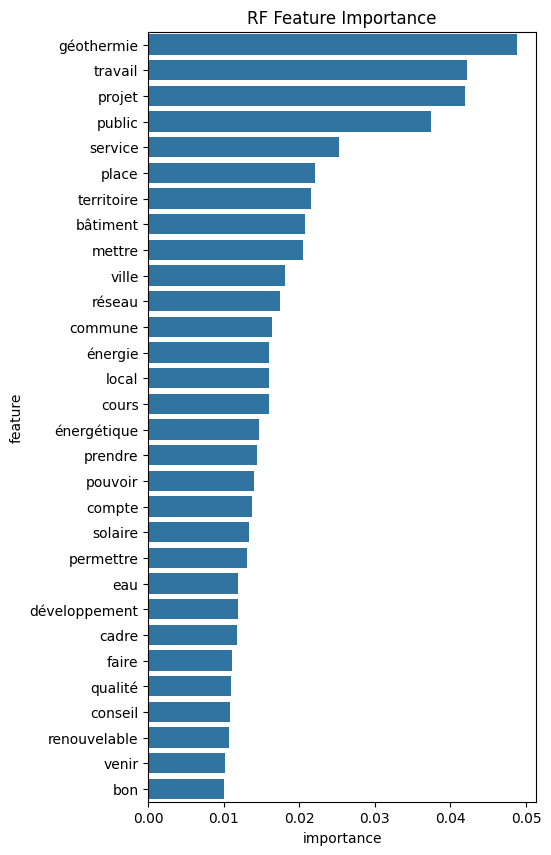

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,10))
sns.barplot(data=df_imp_slice, x="importance", y="feature")
plt.title("RF Feature Importance")
plt.show()

In [110]:
# predicted_probas = rf.predict_proba(X)
# predicted_labels = rf.predict(X)

# max_preds_array = []
# for pred_array in predicted_probas:
#     max_pred = np.max(pred_array)
#     max_preds_array.append(max_pred)

# prediction_tup = tuple(zip(max_preds_array, predicted_labels))
# df_preds = pd.DataFrame(prediction_tup, columns=["prob", "class"])
# df_preds.value_counts("prob")

# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.displot(data=df_preds, x="prob", hue="class")
# plt.show()

##### SHAP

In [166]:
import shap

shap.initjs()

explainer= shap.TreeExplainer(rf)
shap_values = explainer(X)

In [167]:
np.shape(shap_values.values)

(2000, 2499, 2)

In [168]:
# most_rel_features

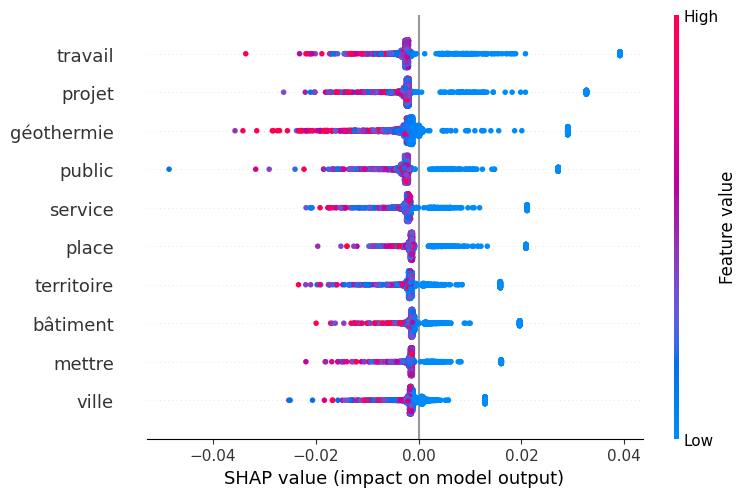

In [170]:
shap.plots.beeswarm(shap_values[:, most_rel_features[0:10], 1]) # passing the list of more relevant fts (first 10)
                # data point | feature |class

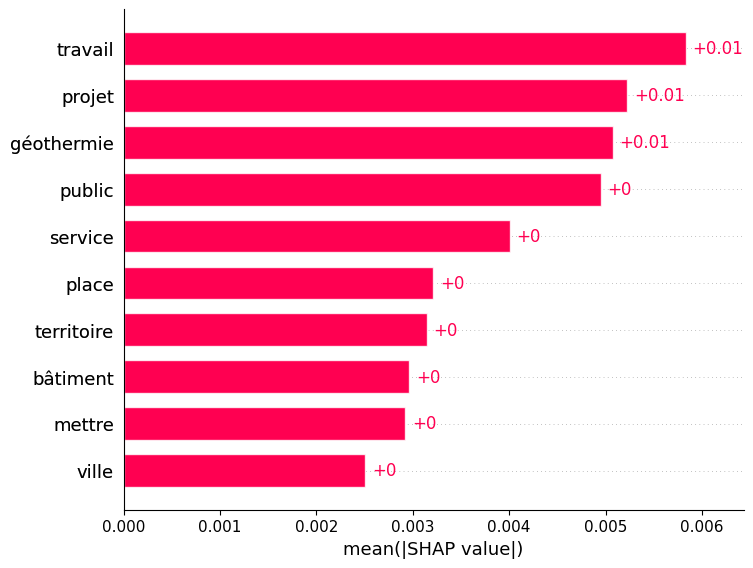

In [171]:
shap.plots.bar(shap_values[:, most_rel_features[0:10], 1])
